<a href="https://colab.research.google.com/github/ManojithBhat/4th-Sem-Lab-programs/blob/main/land_use_land_cover_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automating Land Use and Land Cover Mapping using Python
**Content Creators**: Ankur Mahesh and Isabelle Tingzon

This is a continuation of [Part 1 of the Land Use and Land Cover (LULC) Mapping Tutorial](https://github.com/climatechange-ai-tutorials/lulc-classification/blob/main/land_use_land_cover_part1.ipynb). Previously, you learned how to train a deep learning model to classify Sentinel-2 image patches into different land use and land cover categories.

In this tutorial, you will learn how to:
- download your own Sentinel-2A satellite images using Google Earth Engine
- use the trained model from the previous tutorial to automatically generate a LULC map for a region of interest

You can make a copy of this tutorial by navigating to File->Save a copy in Drive.

## Table of Contents
1. [Introduction to Geospatial Data]()
2. [Download Country Boundaries](#admin-bounds)
3. [Generate Sentinel-2 Satellite Image](#sentinel-2)
4. [Generate 64x64 px GeoJSON Tiles](#tiles)
5. [Generate LULC Map](#lulc-maps)
6. [Conclusion & Next Steps]()

# Introduction to Geospatial Data

This tutorial covers an introduction to geospatial data processing using Python. Our aim is to introduce basic concepts and commonly used tools to manipulate, analyze, and visualize geospatial data. Our targeted audience are those who are new to Python as a tool for geospatial data analysis, as well as beginners in geospatial data analysis and are looking for tools to get started.

## Spatial Data Types
Spatial data observations focus on *location*. There are two main types of spatial data:
- **Vector data** - are basically points, lines, and polygons. Each vector object can consist of one or more XY coordinate locations. Vectors can be used to represent, for example, locations of places (e.g. schools, hospitals), roads, or country boundaries. Vector objects can be stored using spatial data formats such as GeoJSON (.geojson), GeoPackage (.gpkg), Shapefile (.shp).
- **Raster data** - are composed of a grid of pixels. Examples include multispectral satellite images, nighttime luminosity maps, and digital elevation maps. Each pixel represents a value or class, e.g. red, green, blue values in satellite images; night light intensity in NTL maps; height in elevation maps. Raster data are commonly stored as GeoTIFFs (.tiff).

To learn more about vectors and raster, [see this reference](https://gisgeography.com/spatial-data-types-vector-raster/).

<img src="https://slideplayer.com/slide/6229417/20/images/10/Spatial+data%3A+Vector+vs+Raster.jpg=100x100" width="350"/>

## Coordinate Reference Systems
Map projections are 2D representations of the earth on a flat surface. But because the earth is spheroidal, there is no single most accurate way to represent the earth in two dimensions, resulting in a number of coordinate systems that serve different purposes (recommended watching: ["Why all world maps are wrong" by Vox](https://www.youtube.com/watch?v=kIID5FDi2JQ&ab_channel=Vox)).

**Coordinate reference systems** (CRS) provide a method for defining real-world locations in geographic space. These systems determine not just the coordinate locations of objects but also how your map looks and how distance is calculated.

Geospatial data - whether vector and raster - is always accompanied by CRS information. Two common coordinate systems are EPSG:3857 (Web Mercator) and EPSG:4326 (WGS 84) - in this tutorial, we'll be using the latter CRS.

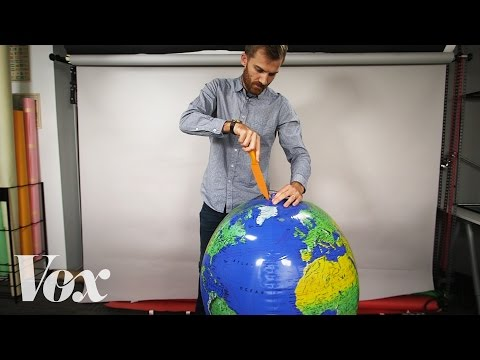

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('kIID5FDi2JQ')

## Geospatial Data Processing Tools
We introduce the following geospatial analysis tools and Python packages:

- [**Google Earth Engine**](https://earthengine.google.com/) - a public data archive of petabytes of historical satellite imagery and geospatial datasets. In this tutorial, we will use the [Python Earth Engine API](https://developers.google.com/earth-engine/#api) to access Sentinel-2 RGB images. Note that you will need sign up for access to Google Earth Engine at https://code.earthengine.google.com/.
- [**GeoPandas**](https://geopandas.org/) - Extends the functionalities of pandas to add support for geographic data and geospatial analysis.
- [**Rasterio**](https://rasterio.readthedocs.io/en/latest/) - Raster data such as satellite images are often stored using the GeoTIFF format. Rasterio allows you to read and write these formats and perform advanced geospatial operations on these datasets.  
- [**Folium**](https://python-visualization.github.io/folium/) - Allows you to visualize geospatial data on an interactive leaflet map.

For more geospatial analysis tools, see this [comprehensive list of Python packages](https://github.com/giswqs/python-geospatial).

# Imports and Setup

In [2]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [3]:
# Standard imports
import os
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep learning libraries
import torch
from torchvision import datasets, models, transforms

### Mount Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Authenticate Google Earth Engine
Make sure you have signed up for access to Google Earth Engine at https://signup.earthengine.google.com/#!/. Once your request has been approved, you should be able to access Google Earth Engine at https://code.earthengine.google.com/.

In [15]:
ee.Authenticate()
ee.Initialize(project="lulc-sde-el")

<a name="admin-bounds"></a>
# Download Country Boundaries

Our first step is to download the administrative boundaries of our country of interest, which we will obtain via [geoBoundaries by the William and Mary GeoLab](https://www.geoboundaries.org/index.html). geoBoundaries is a free and openly accessible global database of political administrative boundaries for every country in the world. The geographic boundaries can be downloaded via API access through a simple query:

```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
- **ISO** - The three-letter ISO code representing the country of interest.
  - [See this page](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) for the complete list of ISO codes per country.
- **ADM** - One of ADM0, ADM1, ADM2, ADM3, ADM4 or ADM5, representing each level of administrative hierarchy.

For more information, see [API documentation](https://www.geoboundaries.org/api.html).

In this example, we choose **Germany** as our area of interest. We set the ISO code to "DEU" and ADM to "ADM2". The query should return the geometries for all 403 administrative districts in Germany. In the following cell, we send a request for the Germany admin boundaries, save the result as a GeoJSON file, and read the file using GeoPandas.

In [24]:
ISO = 'DEU' # "DEU" is the ISO code for Germany
ADM = 'ADM3' # Equivalent to administrative districts

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(3)

Data dimensions: (428, 6)


,shapeName,shapeISO,shapeID,shapeGroup,shapeType,geometry
248,"Remscheid, Kreisfreie Stadt",,24449704B51434706653062,DEU,ADM3,"POLYGON ((7.29581 51.20539, 7.29445 51.20582, ..."
130,Aichach-Friedberg,,24449704B6694000940165,DEU,ADM3,"POLYGON ((11.31167 48.45227, 11.31092 48.45292..."
353,Anhalt-Bitterfeld,,24449704B57933399252920,DEU,ADM3,"MULTIPOLYGON (((12.27672 52.10402, 12.27285 52..."


In this example, we visualize the adminstrative boundary for district **Kreis Borken** using the GeoPandas `.plot()` function.

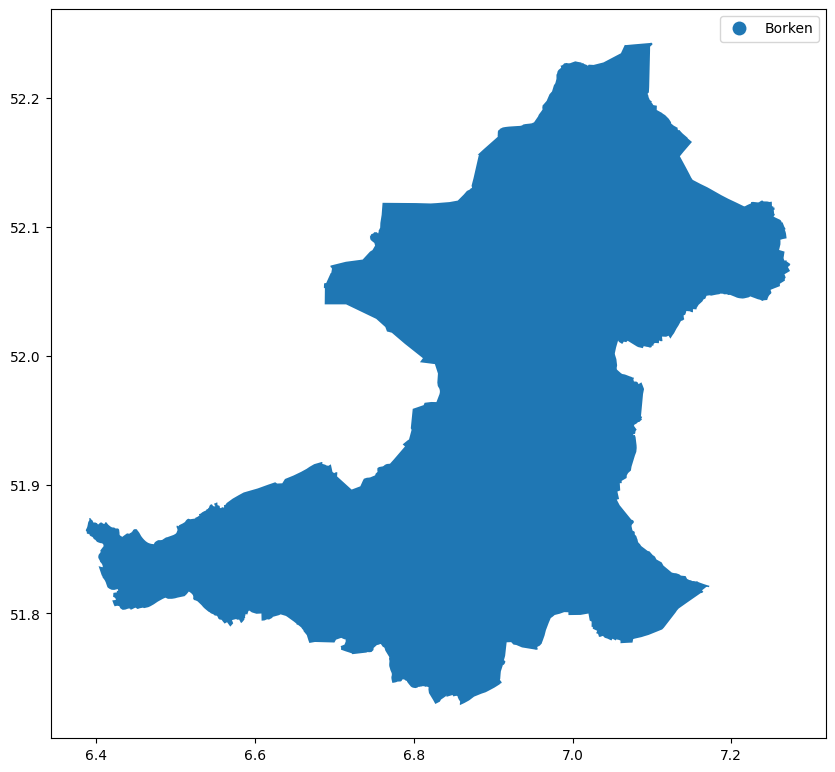

In [25]:
shape_name = 'Borken'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

<a name="sentinel-2"></a>
# Generate Sentinel-2 Satellite Images
Sentinel-2 is an Earth observation mission from the Copernicus Programme that provides global multispectral imagery every 10 days (2015 - present) at 10 m resolution (i.e. the length of one side of a pixel is equal to 10 meters).

Images are typically composed of 3 channels or bands: red, green, and blue. Sentinel-2, on the other hand, is able to capture 13 spectral bands:
- 4 bands at 10 meter: blue, green, red, and near-infrared
- 6 bands at 20 meter: for vegetation characterization and for applications such as snow/ice/cloud detection or vegetation moisture stress assessment.
- 3 bands at 60 meter: mainly for cloud screening and atmospheric corrections


&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>

For simplicity, we only used the Red, Green, and Blue bands for LULC classification in this tutorial. However, multispectral data contains rich information that can be useful for a number of applications including crop yield estimation, vegetation health monitoring, built-up area expansion analysis, informal settlement detection, and so much more. We highly encourage you to explore the full potential of Sentinel-2 satellite imagery for climate-related applications.

[Learn more about Sentinel-2 here](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects).


## Google Earth Engine
In this section, we will demonstrate how to use Google Engine to download Sentinel-2 satellite imagery. Again, for simplicity, we will only download Sentinel-2 RGB bands - red (B4), green (B3), and blue (B2).

In the following cell, we define a function to generate a Sentinel-2 image from Google Earth using the Python Earth Engine API. In order to minimize cloud cover, we chose to aggregate a collection of images over a period of time, as opposed to obtaining a single image on a given date.

In [20]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2023-04-20',  # Start date
    max_date='2023-05-03',  # End date
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

# min_date='2020-01-01',
#     max_date='2020-01-01',

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """



    # Generate median aggregated composite
    image = ee.ImageCollection(product) \
        .filterBounds(region) \
        .filterDate(min_date, max_date) \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct)) \
        .median()  # Calculate the median composite

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [26]:
import ee
import shapely.geometry as geometry
from shapely.ops import transform
import pyproj
from functools import partial


def create_region_from_coordinates(coords):
    """Creates an ee.Geometry region from a list of coordinates.

    Args:
        coords (list): A list of dictionaries, each containing 'lat' and 'lng' keys.

    Returns:
        ee.Geometry: The region represented as an ee.Geometry Polygon.
    """

    # Create a shapely Polygon from the coordinates
    polygon = geometry.Polygon([(p['lng'], p['lat']) for p in coords])

    # Reproject to EPSG:3857 if needed
    # (assuming the input coordinates are in EPSG:4326)
    project_WGS_to_UTM = partial(
        pyproj.transform,
        pyproj.Proj(init='epsg:4326'),
        pyproj.Proj(init='epsg:3857'),
    )
    polygon_proj = transform(project_WGS_to_UTM, polygon)

    # Convert shapely Polygon to GEE Geometry
    gee_region = ee.Geometry.Polygon(list(polygon_proj.exterior.coords))

    return gee_region


# Example usage with your coordinates:
coords = [
  {
    "lat": 13.012418776597308,
    "lng": 77.61751967816008
  },
  {
    "lat": 13.010411728475365,
    "lng": 77.70571231536594
  },
  {
    "lat": 12.946512219512973,
    "lng": 77.68786789071729
  },
  {
    "lat": 12.947516003589811,
    "lng": 77.6212944602973
  },
  {
    "lat": 12.980973157534004,
    "lng": 77.59126778420581
  }
]

region = create_region_from_coordinates(coords)
print(region)



# Now you can use this 'region' in the generate_image function:
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

Map = emap.Map(zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              8640342.767209671,
              1461151.1234423579
            ],
            [
              8650160.326675143,
              1460921.8123575023
            ],
            [
              8648173.894409757,
              1453622.0761562686
            ],
            [
              8640762.974035043,
              1453736.7316986956
            ],
            [
              8637420.419742323,
              1457558.5831129549
            ],
            [
              8640342.767209671,
              1461151.1234423579
            ]
          ]
        ]
      },
      "evenOdd": {
        "constantValue": true
      }
    }
  }
})


/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.11/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.11/dist-packages/shapely/ops.py:259: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior

KeyError: 'geometry'

We generate and visualize the Sentinel-2 satellite image for Kreis Borken. The satellite image is generated by getting the median of all Sentinel-2 images in 2020 with a cloud cover of less than 10%.

In [ ]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Export Image to Local Gdrive
In the following cell, we define a function to export our generated Sentinel-2 satellite image to our local Google Drive.

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

We can now proceed to download the image to our local Google Drive as a GeoTIFF.

**Note**: Be careful about exporting large images as they can take a while to download and could eat up storage space!

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

You can repeatedly run `task.status()` to monitor the state of the task. After a while, the state should change from "READY" to "RUNNING" to "COMPLETE".

Alternatively, you can go to https://code.earthengine.google.com/ to check the status of the task.

In [ ]:
task.status()

## Visualize Sentinel-2A Image

Once the task status changes to "COMPLETE", check that the satellite image is in your google drive.

In the following cell, we load and visualize the satellite raster image using the Rasterio library.

In [ ]:
# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(shape_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generate 64x64 px GeoJSON Tiles

Recall that in previous tutorial, we trained a deep learning model on the [EuroSAT RGB dataset](), which consists of 64x64 pixel Sentinel-2 image patches. This means that we will also need to break down our huge Sentinel-2 image into smaller 64x64 px tiles.

Let's start by creating a function that generates a grid of 64x64 px square polygons using [Rasterio Window utilities](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the Kreis Borken Sentinel-2 satellite image.

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

## Visualize 64x64 px Tiles

Let's open the Sentinel-2 raster file using Rasterio and superimpose the 64x64px vector polygons as follows.

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Notice that the polygons are generated for empty (black) regions as well. Using our model to predict on blank regions seems computationally wasteful.

Instead, we can get the intersection between:
- the Kreis Borken boundary polygon and
- the 64 x 64 grid tiles.

To do this, we use GeoPandas `.sjoin()` function. We set parameter `op='within'` to indicate that we only want the tiles that lie within the district boundary.

[See  more information on GeoPandas sjoin operation here](https://geopandas.org/reference/geopandas.sjoin.html).


In [ ]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, op='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image
We can now crop our Sentinel-2 image using the generated grids.

Here, we visualize the Sentinel-2 image cropped using the first tile.

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

<a name="lulc-maps"></a>
# Generate Land Use and Land Cover Map
In this section, we will generate our land use and land cover classification map using the trained model from the previous tutorial. Recall that the EuroSAT dataset consists of 10 different LULC classes as listed below.

In [ ]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

## Load Model trained on EuroSAT
First, load your trained model.

In case you missed Part 1 of the tutorial, you can also uncomment the code below to download the trained model directly.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_file = cwd+'/models/best_model.pth'

# Uncomment this to download the model file
if not os.path.isfile(model_file):
  model_file = 'best_model.pth'
  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model.load_state_dict(torch.load(model_file, map_location=device))
model.eval()

print('Model file {} successfully loaded.'.format(model_file))

Remember in the previous tutorial that we applied a set of data transformations to our test set. Before we run our new images through the model, we'll need to apply these same transformation to our new data as follow.

In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Model Prediction & LULC Map Generation

Next, let's define a function that:
1. Crops the source image using the 64x64 tile geometry
2. Generates a prediction for the cropped image using the trained model

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)

        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

Let's iterate over every 64x64 px tile and generate model predictions for the corresponding cropped image. Note that we are overwriting each temporary TIFF file to save storage space.

In [ ]:
# Commence model prediction
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Save predictions
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

## Visualize Interactive LULC Map
Lastly, we show you how to generate an interactive LULC map using Folium.

Let's start by loading the resulting predictions.

In [ ]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Uncomment this to download the model predictions
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

We then map each label to a corresponding color.

In [ ]:
# We map each class to a corresponding color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

Note that you can toggle the map on/off using the upper right controls.

In [ ]:
# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map

# Conclusion
Congrats on making it to the end! To recap, in this tutorial, you've learned how to download a Sentinel-2 satellite image for a region of interest using Google Earth Engine and apply a trained CNN model to generate a land use and land cover map. As an exercise, try applying the model to another region, e.g. your home country. How well does the model perform in this new geography?

## Data Limitations
If you've tried applying the model to another region of the world, you'll find that the model does not perform as well for certain areas. We note some of the limitations of the EuroSAT dataset as follows:
- **Limited scene categories.** The 10 land cover classes in the EuroSAT dataset are not representative of the complex content of remote sensing data. These class labels are not mutually disjoint (e.g. an image can contain both a highway and a residential area) and their union does not cover real-world distribution (e.g. certain land cover types like desert land and aquaculture are not present in the dataset).
- **Limited model transferrability.** Like many existing remote sensing datasets, EuroSAT, which consists of satellite images distributed across Europe, suffers from limited geographic coverage which restricts the model's generalizability to other regions of the world. Thus, collaboration with diverse research institutions and stronger data sharing efforts are necessary to improve the global coverage of annotated remote sensing datasets.

## Climate-related Applications
- **Land use and land cover change detection.** Given that Sentinel-2 will continue to collect RS data for the next several decades, one promising next step is to use the trained model to observe and detect changes in land cover. [MapBiomas](https://plataforma.brasil.mapbiomas.org/), for example, is a platform that visualizes LULC changes in Brazil over a long period of time. This can be particularly useful for urban planning, environmental monitoring, and nature protection. Deforestation, for example, contributes significantly to climate change; monitoring changes in forest cover and identifying drivers of forest loss can be useful for forest conservation and restoration efforts.
- **Analyzing carbon emissions from land use change.**  Analyzing land use category conversion in conjunction with changes in soil carbon storage can help quantify the contribution of land use change and land management to total carbon emissions, as demonstrated in this [2016 study by Lai et al](https://advances.sciencemag.org/content/2/11/e1601063). The study found that land use change - particularly urbanization, which has led to rapid expansion of built-up areas and massive loss of terrestrial carbon storage - has resulted in large carbon emissions in China. This can significantly undermine carbon emission reduction targets unless appropriate measures are taken to control urbanization and improve land management.
- **Vulnerability assessment of different land cover types.** Overlaying land cover maps with various geospatial hazard maps (e.g. hurricane paths, earthquake faults, and flood maps) and climate projection maps can be useful for assessing vulnerability of certain land cover types, such as settlements and agricultural land, to different risks. When shared with humanitarian organizations and government agencies, these maps have the potential to support disaster risk reduction planning as well as long-term climate mitigation and adaptation efforts.

## Other Remote Sensing Datasets
- So2Sat LCZ42: A benchmark dataset for global local climate zones classification  ([data](https://mediatum.ub.tum.de/1483140), [paper](https://arxiv.org/pdf/1912.12171.pdf))
- RESISC45: High resolution remote sensing scene classification dataset( [data](https://www.tensorflow.org/datasets/catalog/resisc45), [paper](https://arxiv.org/abs/1703.00121))
- BigEarthNet: Large-Scale Sentinel-2 Benchmark ([data](http://bigearth.net/), [paper](https://arxiv.org/abs/1902.06148))

[Check out this Github repository](https://github.com/chrieke/awesome-satellite-imagery-datasets) for a more comprehensive collection of satellite imagery datasets.

## Next Steps
**Interested in learning more about climate change and machine learning?**

We encourage you to check out [our paper](), which provides a detailed guide of ways machine learning can be used to tackle climate change. Please also feel free to check out our [wiki]() and [tutorials]() on our website. We also encourage you to join the conversations on our [discussion forum](), submit to our [workshops](), attend our [events]() and [workshops](), and of course, sign up for our [newletter]()!

# Feedback
Have any comments/suggestions/feedback? Interested in collaborating?

Contact us at:
*   ankur.mahesh@berkeley.edu
*   issatingzon@climatechange.ai
*   milojevicdupontn@gmail.com



# References
- Coordinate Reference Systems – Introduction to Geospatial Concepts. (n.d.). Data Carpentry - Introduction to Geospatial Concepts. Retrieved February 14, 2021, from https://datacarpentry.org/organization-geospatial/03-crs/
- USGS EROS Archive - Sentinel-2. (n.d.). USGS. Retrieved February 14, 2021, from https://www.usgs.gov/centers/eros/science/usgs-eros-archive-sentinel-2?qt-science_center_objects=0#qt-science_center_objects
- Long, Yang, Gui-Song Xia, Shengyang Li, Wen Yang, Michael Ying Yang, Xiao Xiang Zhu, Liangpei Zhang, and Deren Li. “DIRS: On creating benchmark datasets for remote sensing image interpretation.” arXiv preprint arXiv:2006.12485 (2020). https://arxiv.org/pdf/1912.12171.pdf
- Zhu, Xiao Xiang, et al. “So2Sat LCZ42: A benchmark dataset for global local climate zones classification.” arXiv preprint arXiv:1912.12171 (2019). https://arxiv.org/pdf/1912.12171.pdf
- Sumbul, Gencer, et al. "Bigearthnet: A large-scale benchmark archive for remote sensing image understanding." IGARSS 2019-2019 IEEE International Geoscience and Remote Sensing Symposium. IEEE, 2019.
- Lai, Li, et al. "Carbon emissions from land-use change and management in China between 1990 and 2010." Science Advances 2.11 (2016): e1601063.